#CO70058 Computer Vision
#Tutorial 8 - Motion and Optical Flow


references:
*   Udacity - Introduction to Computer Vision Course

## Theory

For matching points points between two viewpoints we can either:
*   Detect a sparse set of features and match them between two viewpoints (like we did on previous tutorial/coursework);
*   Use a dense method (e.g., optical flow) assuming that the viewpoints are very similar, or that the target object did not move too fast relative to the camera.

In this tutorial we will focus on optical flow!

### Example applications

*   Background subtraction (static camera and static scene)

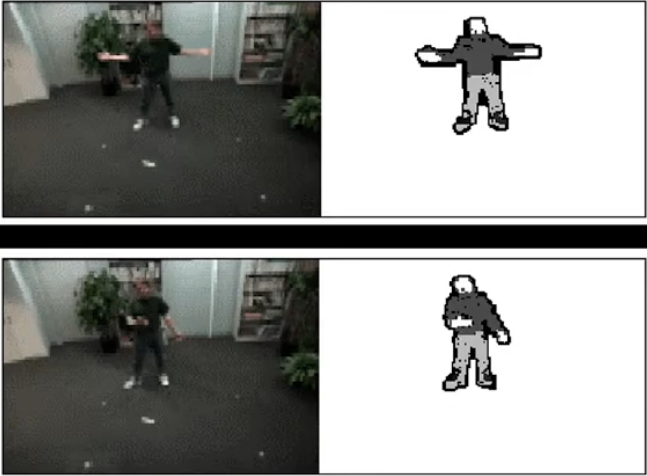

*   Shot boundary detection

Goal: Find out in which frames did they "cut" the video (since there will be a sudden change in the intensity values of the pixels).


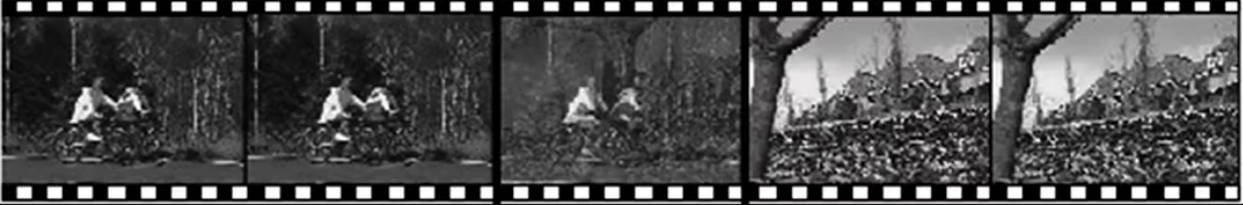

*   Motion Segmentation

Imagine that you have multiple objects, moving differently relative to a static camera and scene. Depending on the detected different motions you could segment the different objects.




*   Motion Stabilization
*   Estimating 3D structure
*   Occlusion detection
*   ...

### Motion and the brain

Sometimes motion is the only cue that our brain can use.

Image 1:

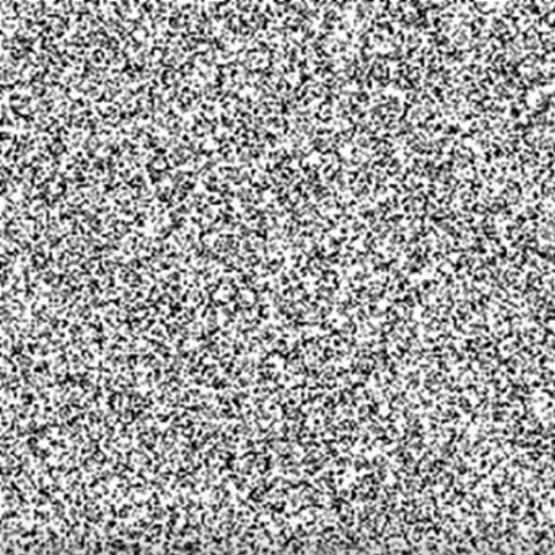

Image 2:

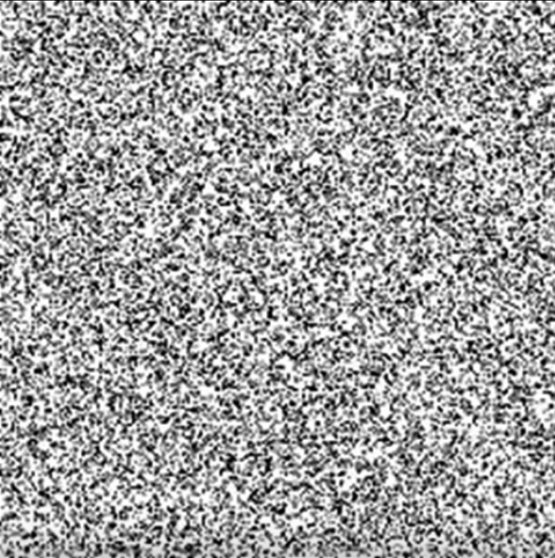

Gif switching between them:

![motion](https://media.giphy.com/media/BD5xcdo7HUXg6XR4ZM/giphy.gif "motion")

Our brains perceive motion, even if the images are so similar. How can we get the computer to manufacture some of this information?

### How do the dense methods work?

These algorithms recover image motion by analysing image brightness variations. This works for video and when the framerate is high.

### Optical Flow


YouTube videos:

*   [Optical Flow - Computerphile - Part 1](https://www.youtube.com/watch?v=5AUypv5BNbI)
*   [Optical Flow - Computerphile - Part 2](https://www.youtube.com/watch?v=4v_keMNROv4)

Optical flow is the **apparent** motion of pixels. 

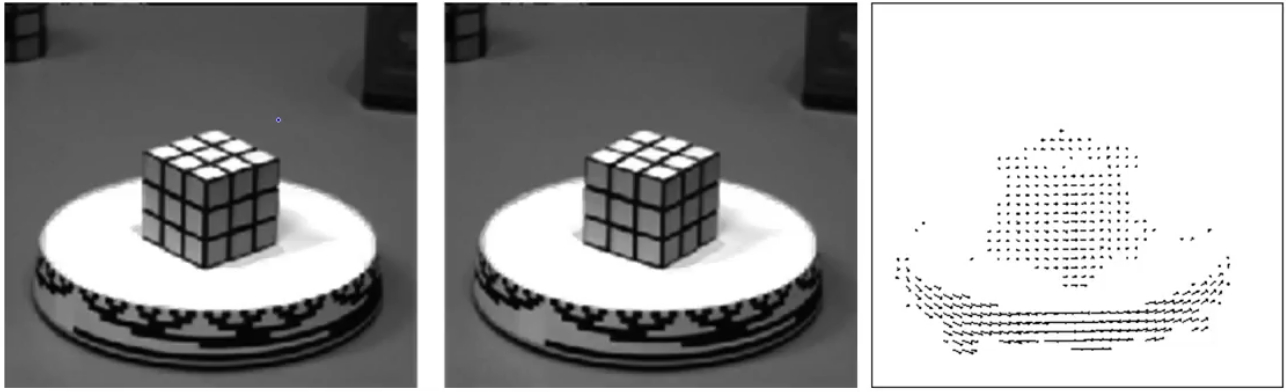

It's **apparent** since in some regions you cannot predict any motion, for example in the white part of the turntable, since there is no change in intensity although that part is also moving.

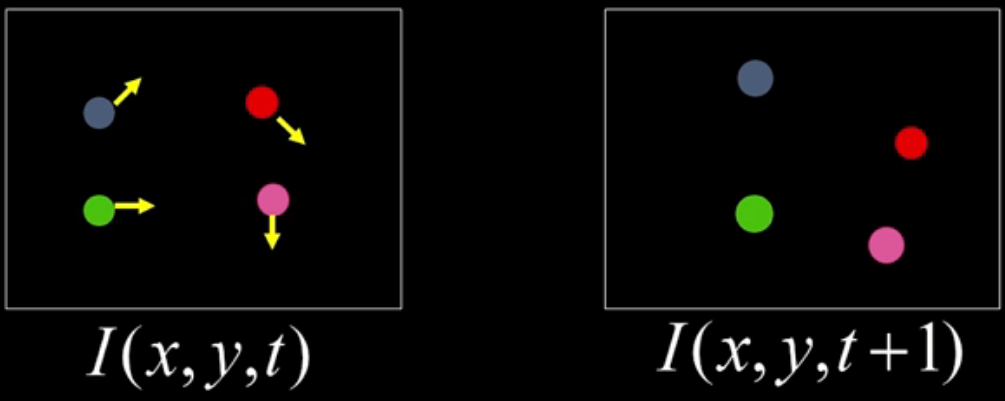

The goal of the optical flow is to estimate the motion of the pixels from one frame to the another. To do this we look for neraby pixels of the same color. So the optical flow has two main assumptions:

1.   **Color constancy**: The intensity values of a point (e.g., the red circle in the image above) remain the same, as that point moves around the image;
2.   **Small motion**: The points do not move very far from one frame to the next one. In practice, this means sub-pixel level of motion.

So right now we can already understand that there are some limitations to optical flow usage. We need the framerate to be very high to have small motion. We can also understand that shadows will create issues, since when we have a shadow over an object it gets darker, which makes the color constancy assumption fail.

So if a point ($x$, $y$) moves by $u$ and $v$. Our colour constancy constrain would be:

\begin{equation}
I(x+u, y+v, t+1) - I(x, y, t) = 0
\end{equation}

And our small motion constrain would be, for example:

\begin{equation}
u < 1 [pixel]
\end{equation}

\begin{equation}
v < 1 [pixel]
\end{equation}

### What is the aperture problem?

When you see this animation, where do you think the red arrow is moving to?



![ApertureProblem](https://media.giphy.com/media/5liREgjFllBQ392Px3/giphy.gif "ApertureProblem")

Going down?


Well, personally I thought the red arrow was moving down, but another possible case would be if it was moving to the right, like so:

![ApertureProblem2](https://media.giphy.com/media/CoRULzN047CphFAmKv/giphy.gif "ApertureProblem2")

### What is the focus of expansion (FOE)?

Let us start with the simple case of a single object moving through a fixed background, with a fixed camera position. In this case, homer is the moving object:

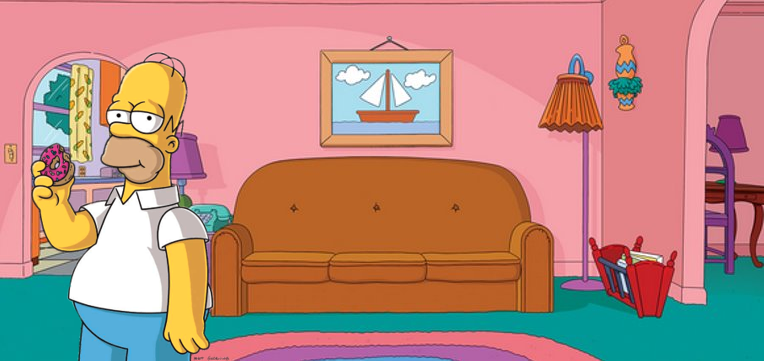

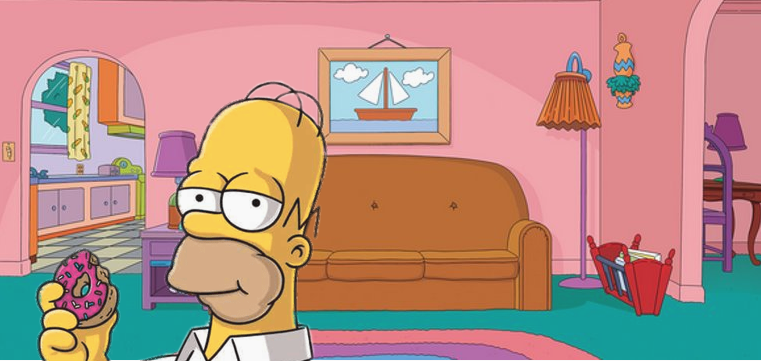

We can define a focus of expansion for Homer:

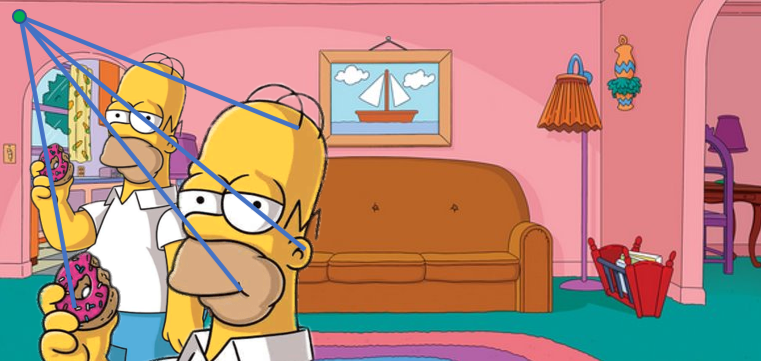

The focus of expansion is the single point on the projected image where the object appears to be comming from. Illustrated with the green circle in the image above.

If both the object and the camera move, we will have two FOEs, one for the background (associated with the motion of the camera) and one for the moving object. This is illustrated in the following image:

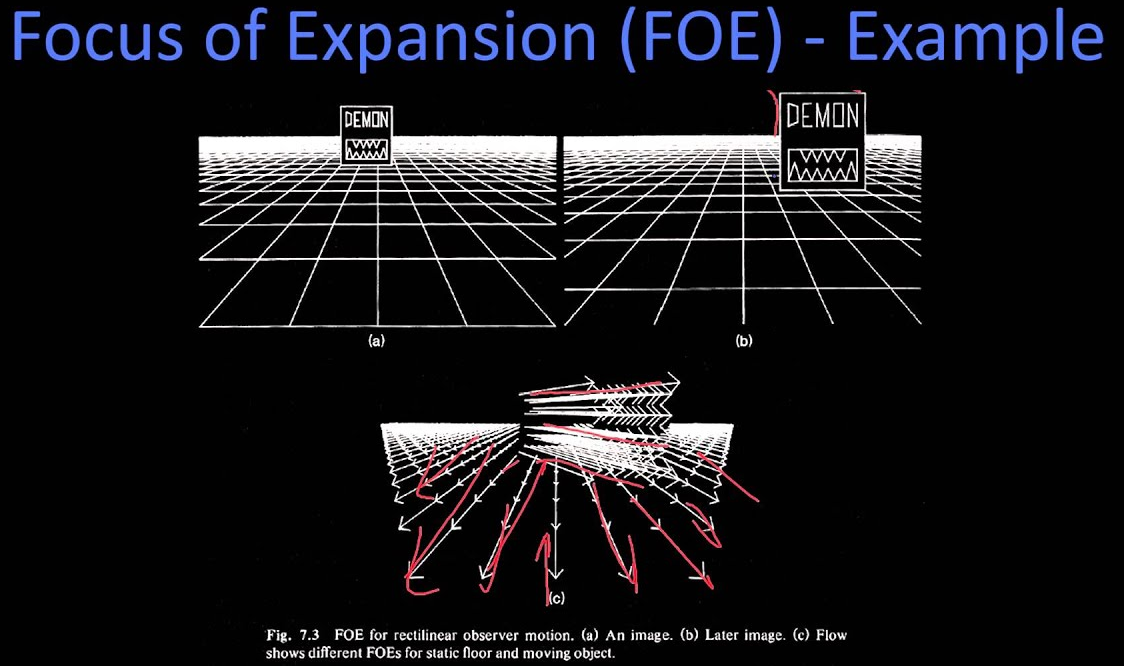

## Question 1

In the shown images we have two types of background textures:
*   Blank
*   Wood

And we have three types of moving objects (squares) whith the following textures:
*   Blank
*   Checkerboard
*   Diagonal stripes

Let's assume that the squares have no black borders. It was just added there for illustration.

In each of the shown images the square will be moving towards the top right corner of the image. 

# Question 2

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## load images and smooth the images via 5 $\times$ 5 Gaussain kenrnel

In [ ]:
frame_1 = cv2.imread('frame10.png', 0)/255
frame_2 = cv2.imread('frame11.png', 0)/255

frame_1 = cv2.GaussianBlur(frame_1,(5,5),0)
frame_2 = cv2.GaussianBlur(frame_2,(5,5),0)

## Generate the kernel to computer the gradients of image at x and y direction

In [ ]:
s_x = (np.array([-1, 8, 0, -8, 1])/12).reshape(1,-1)
print(s_x.shape)
s_y = s_x.T
print(s_y.shape)

(1, 5)
(5, 1)


## Apply 2D convolution 

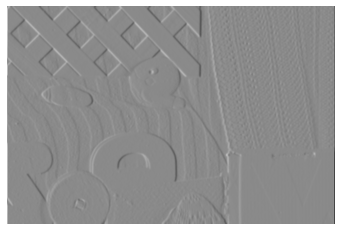

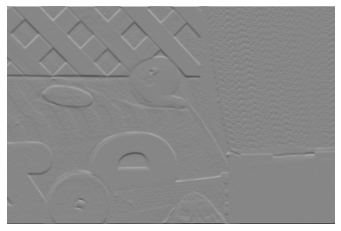

In [ ]:
f_1_x = cv2.filter2D(frame_1, -1, cv2.flip(s_x, -1), borderType=cv2.BORDER_CONSTANT)
plt.imshow(f_1_x, cmap='gray')
plt.axis('off')
plt.show()
f_1_y = cv2.filter2D(frame_1, -1, cv2.flip(s_y, 0), borderType=cv2.BORDER_CONSTANT)
plt.imshow(f_1_y, cmap='gray')
plt.axis('off')
plt.show()

## Compute the derivative $I_t$ between frame 1 and frame 2

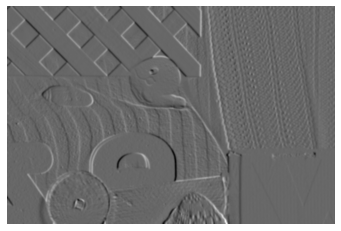

In [ ]:
I_t = frame_2 - frame_1
plt.imshow(I_t, cmap='gray')
plt.axis('off')
plt.show()

## Apply the 5 $\times$ 5 gaussian kernels to $I_x$, $I_y$ and $I_t$

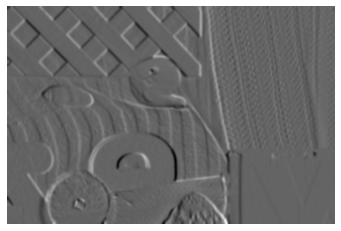

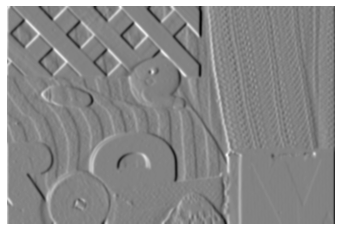

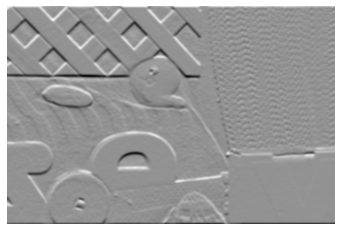

In [ ]:
I_t = cv2.GaussianBlur(I_t,(5,5),0)
plt.imshow(I_t, cmap='gray')
plt.axis('off')
plt.show()

f_1_x = cv2.GaussianBlur(f_1_x,(5,5),0)
f_1_y = cv2.GaussianBlur(f_1_y,(5,5),0)

plt.imshow(f_1_x, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(f_1_y, cmap='gray')
plt.axis('off')
plt.show()

## According to Lucas-Kanade Method, the velocity at x and y direction is uniform in the defined window. Following formula can be acquired (each pixel in the defined window):
$$I_x \times V_x + I_y \times V_y = - I_t$$
## To use least square to solve $V$:
$$ G_{N \times 2} \cdot V_{2\times 1} = D_{N\times 1}$$
$$ (G_{N \times 2} \cdot V_{2\times 1} - D_{N\times 1})^2 = 0$$
$$ 2G_{N\times 2}^{T}(G_{N \times 2} \cdot V_{2\times 1} - D_{N\times 1})= 0$$
$$V = (G_{2\times N}^{T}G_{N\times 2})^{-1}G_{2\times N}^{T}D_{N\times 1}$$

In [ ]:
def LK_method(I_x, I_y, I_t, block_size):
    h, w = I_t.shape
    
    step_x = w // block_size
    step_y = h // block_size

    v_x = np.zeros((step_x, step_y))
    v_y = np.zeros((step_x, step_y))

    c_x = np.zeros((step_x, step_y))
    c_y = np.zeros((step_x, step_y))

    for i in range(step_x):
        for j in range(step_y):
            I_x_block = I_x[j * block_size:(j+1) * block_size, i * block_size:(i+1) * block_size]
            I_y_block = I_y[j * block_size:(j+1) * block_size, i * block_size:(i+1) * block_size]
            I_t_block = - I_t[j * block_size:(j+1) * block_size, i * block_size:(i+1) * block_size]
            I_x_block = I_x_block.flatten().reshape(-1, 1)
            I_y_block = I_y_block.flatten().reshape(-1, 1)
            I_t_block = I_t_block.flatten().reshape(-1, 1) 
            I_g_block = np.concatenate((I_x_block, I_y_block), axis=1)
            # V = np.dot(np.linalg.pinv(I_g_block), I_t_block)
            M_inv = np.linalg.pinv(np.dot(I_g_block.T, I_g_block))
            V = np.dot(np.dot(M_inv, I_g_block.T), I_t_block)
            v_x[i, j] = V[0, :]
            v_y[i, j] = V[1, :]

            c_x[i, j] = (block_size // 2) + 1 + i * block_size
            c_y[i, j] = (block_size // 2) + 1 + j * block_size

    return v_x.flatten(), v_y.flatten(), c_x.flatten(), c_y.flatten()


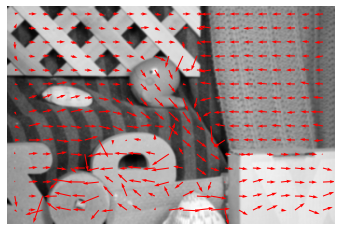

In [ ]:
v_x, v_y, c_x, c_y = LK_method(f_1_x, f_1_y, I_t, 25)
plt.imshow(frame_1, cmap='gray')
M = np.hypot(v_x, v_y)
plt.axis('off')
plt.quiver(c_x, c_y, v_x, v_y, color='red')